# Applied Deep Learning Tutorial 
# Generative Adversarial Neural Networks (GANs)

## Introduction
In this tutorial, you will attempt to implement a Generative Adversarial Neural Network for image generation on the MNIST dataset. Labeled training data is the fuel for supervised machine learning approaches. Thus GANs can be seen as the holy grail when it comes to generating additional data affiliated with a given source domain. GANs have first been introduced by [Goodfellow et al.](http://arxiv.org/abs/1406.2661)

<img src="graphics/stormtrooper.jpg" width="700"><br>
<center> Fig. 1: Stormtrooper reflects the idea of generating multiple instances of the same source domain. </center>


## Introduction 

GANs are based on a joint training of at least two separate neural networks. The generator and the discriminator.
The generator takes an input, most often a latent random input, and maps this input to an output with the dimensions of a source domain sample, meaning real-world data. The discriminator takes inputs from either the source domain or the generator. The discriminator then does a binary classification, learning to distinguish between generated and real samples.

<img src="graphics/GANarchitecture.jpg" width="700"><br>
<center> Fig. 2: Overview of a simple GAN architecture with discriminator and generator. </center>

The training process happens in two passes. During the first pass the generator is frozen, and the discriminator is trained to distinguish between real and generated samples. 
In the second pass, the discriminator is frozen and the generator is trained using the discriminator classification as objective, backpropagating the error. 
By iteratively repeating those two passes, the quality of the generated samples increases, while the ability of the discriminator of distinguishing between real and generated improves too.


# Build your GAN

Do the necessary imports.
And load the [MNIST](http://yann.lecun.com/exdb/mnist/) data set - the hello world for machine learning.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [6]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("C:\\Users\\Z624284\\Desktop\\VL_Weingarten\\10 Block GenerativeAdversarialNetworks\\ADL_08_Tutorial_Schutera\\data\\", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting C:\Users\Z624284\Desktop\VL_Weingarten\10 Block GenerativeAdversarialNetworks\ADL_08_Tutorial_Schutera\data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting C:\Users\Z624284\Desktop\VL_Weingarten\10 Block GenerativeAdversarialNetworks\ADL_08_Tutorial_Schutera\data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting C:\Users\Z624284\Desktop\VL_Weingarten\10 Block GenerativeAdversarialNetworks\ADL_08_Tutorial_Schutera\data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting C:\Users\Z624284\Desktop\VL_Weingarten\10 Block GenerativeAdversarialNetwork

## Setting up dimensions and initialization

- Determine and define the image dimension, which for MNIST, as we know by now, is 28x28 Pixels, this is the number of inputs to the discriminator.
- The input to the generator will be a random latent variable, the more inputs and thus combinations we allow here, the more variance our generated samples will show.
- Next we will define the dimension (number of neurons) of our hidden layer for the generator network and the discriminator network. Both have one hidden layer, and should be approximately equally complex to keep the balance between the two networks.


In [7]:
# Network Params
image_dim = 784 # 28*28 pixels
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 100 

In [12]:
# Define placeholders for the inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')

## Glorot initialization

We will initialize our weight with the Glorot initialization which was presented in this [paper](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). 

In [8]:
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

## Setting up parameters
Initialize the weights with the Glorot initializer. And initialize the biases as zeroes.

##### Why can we initialize the bias as zeroes?
There is only a single bias per unit, the danger of having the same weight values in one layer is that they will be updated by the same error and hence stay the same. 

In [9]:
# Store layers weight & bias for discriminator and generator
weights = {
    'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden_dim])),
    'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim])),
    
    'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim])),
    'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1])),
}
biases = {
    'gen_hidden1': tf.Variable(tf.zeros([gen_hidden_dim])),
    'gen_out': tf.Variable(tf.zeros([image_dim])),
    
    'disc_hidden1': tf.Variable(tf.zeros([disc_hidden_dim])),
    'disc_out': tf.Variable(tf.zeros([1])),
}

## Designing the Generator

The Generator will be designed as a Fully Connected Neural Network (FCN). Starting from our input x implement the following operations: 
- first we multiply the inputs (first layer) with the weights of the hidden layer.
- add the biases.
- map the output with the ReLU activation function.
- mulitply the output of the hidden layer with the weights of the output layer.
- add the biases.
- map the output with the Sigmoid activation function.

###### Why is the activation function of the output layer realized as sigmoid function?

We need to map our output to a range of values between 0 and 1 or black and white. This nicely is reflected by the range of values of the sigmoid function.




In [13]:
# Generator
def generator(x):
    hidden_layer = tf.matmul(x, weights['gen_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['gen_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['gen_out'])
    out_layer = tf.add(out_layer, biases['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

## Designing the Discriminator

The discriminator will be designed similar to the generator: 
- first we multiply the inputs (first layer) with the weights of the hidden layer.
- add the biases.
- map the output with the ReLU activation function.
- mulitply the output of the hidden layer with the weights of the output layer.
- add the biases.
- map the output with the Sigmoid activation function.

###### Why is the activation function of the output layer realized as sigmoid function?

We need to map our output to a range of values between 0 and 1 or source or generated for binary classification. This nicely is reflected by the range of values of the sigmoid function.

###### Why is the discriminator architecture so similar to the generator? Discuss complexity of the two models with respect to their task.

We need both models to be similar complex to make an iterative interplay possible. If one model would have a peak in performance improvement it might happen, that the other model wouldn't be able to benefit from the feedback of the other model anymore. Thus the complexity of the models should be chosen similar. 
Yet the discriminator has a slightly easier task, doing a binary classification - it is thus adviced to sometimes handicap this model by limitting the complexity or the learning rate.

In [14]:
# Discriminator
def discriminator(x):
    hidden_layer = tf.matmul(x, weights['disc_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['disc_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['disc_out'])
    out_layer = tf.add(out_layer, biases['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

## Discriminator Training

The discriminator is trained on both, samples from source domain and from the generated domain. 


In [15]:
# Build the pipelines for the discriminator network inference

# sample from source
disc_real = discriminator(disc_input)

# sample from generator
disc_fake = discriminator(generator(gen_input))

## Objective Function - Min Max Game

The loss for the discriminator is as follows:
\begin{align}
    -\log_{10}(discriminator_{real})-\log_{10}(1-discriminator_{fake})
\end{align}

For better understanding lets assume a generated sample. When feeding the generated sample into the discriminator and the discriminator is able to detect the domain, the sigmoid output will be a value around 0. The loss should thus be low in this case. We achieve this by capsuling the discriminator output as: 

$\log_{10}(1-discriminator_{fake})$.

- If the generated image is detected as such, the loss will be $-\log(1-(0))=-\log(1)$ and thus tending to become 0. 
- If the generated image is detected as source image, the loss will be $-\log(1-(1))=-\log(0)$ and thus tending to become inifite large. 

##### Elaborate the loss for a real image given to the discriminator
- If the source image is detected as such, the loss will be $-\log(1)$ and thus tending to become 0. 
- If the source image is detected as generated image, the loss will be $-\log(0)$ and thus tending to become inifite large. 

##### Elaborate the loss for the generator
- If the generated image is detected as such, the loss will be $-\log(0)$ and thus tending to become infinite large. 
- If the generated image is detected as source image, the loss will be $-\log(1)$ and thus tending to become 0. 

The loss is determined over multiple samples, thus the mean output of the models is considered

In [17]:
# Build Loss
gen_loss = -tf.reduce_mean(tf.log(disc_fake))
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))

## Setting up the Training and Optimizer

Set up the optimizer as Adam optimizer.


In [20]:
# Build Optimizers

learning_rate = 0.0002

optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Two Pass Training

In Tensorflow by default each optimizer updateds all variables, but in this special architecture we need either two update on the generator or the discriminator only. 

Therefore we define the two passes as separate optimization tasks, while defining the according variables that are affiliated to the pass. 

In [21]:
gen_vars = [weights['gen_hidden1'], weights['gen_out'],
            biases['gen_hidden1'], biases['gen_out']]
disc_vars = [weights['disc_hidden1'], weights['disc_out'],
            biases['disc_hidden1'], biases['disc_out']]

train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

## Start the Training

In [22]:
# Training Params (feel free to mess around with the hyperparameters)
num_steps = 70000
batch_size = 128

sess = tf.Session()
sess.run(tf.global_variables_initializer())

g_loss = []
d_loss = []

for i in range(1, num_steps+1):
    
    # Get batch from MNIST dataset
    batch_x, _ = mnist.train.next_batch(batch_size)

    # Generate latent random variable to feed to the generator, by drawing from a uniform distribution 
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

    # Train
    feed_dict = {disc_input: batch_x, gen_input: z}
    _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                            feed_dict=feed_dict)

    g_loss.append(gl)
    d_loss.append(dl)

    if i % 2000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
        
    print('Training finished.')

Step 1: Generator Loss: 0.425851, Discriminator Loss: 1.797437
Step 2000: Generator Loss: 4.403755, Discriminator Loss: 0.036385
Step 4000: Generator Loss: 4.005747, Discriminator Loss: 0.076955
Step 6000: Generator Loss: 4.062627, Discriminator Loss: 0.100079
Step 8000: Generator Loss: 3.896327, Discriminator Loss: 0.133358
Step 10000: Generator Loss: 3.769361, Discriminator Loss: 0.193675
Step 12000: Generator Loss: 3.849109, Discriminator Loss: 0.199739
Step 14000: Generator Loss: 3.119265, Discriminator Loss: 0.384683
Step 16000: Generator Loss: 3.558293, Discriminator Loss: 0.318301
Step 18000: Generator Loss: 3.954189, Discriminator Loss: 0.171400
Step 20000: Generator Loss: 4.114161, Discriminator Loss: 0.213957
Step 22000: Generator Loss: 3.754085, Discriminator Loss: 0.204052
Step 24000: Generator Loss: 3.055271, Discriminator Loss: 0.354970
Step 26000: Generator Loss: 3.492462, Discriminator Loss: 0.282068
Step 28000: Generator Loss: 3.392847, Discriminator Loss: 0.254529
Ste

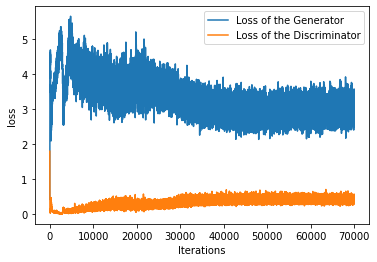

In [23]:
# Plot visualization of the losses, you should pay close attention.
plt.plot(g_loss, label='Loss of the Generator')
plt.plot(d_loss, label='Loss of the Discriminator')
plt.xlabel('Iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

The loss visualization tells us a lot about the training process. 
- Make sure the discriminator does have a continuous loss
- The generator loss should continuously decrease

##### Why do we only load the MNIST images and not the groundtruth? 
The GAN does not care for class labels, and the domain labels are already given by the pipeline.


## Taking the Generator for a ride.

After training the generator, we do a visual check of the generated samples.

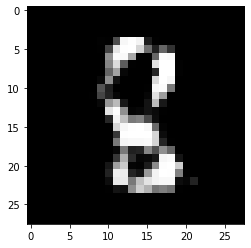

In [38]:
# Testing
# Generate images from a latent random variable, using the generator network.
# first we will create an empty np.array with the size of 28x28 
canvas = np.empty((28, 28))

# We will generate the latent random variable drawing from the uniform distribution in [-1, 1] as a 1x100 tensor
z = np.random.uniform(-1., 1., size=[1, noise_dim])

# we will now feed z as input to the generator
g = sess.run(generator(gen_input), feed_dict={gen_input: z})

# The generated sample is reshaped and visualized.
canvas[0:28, 0:28] = g[0].reshape([28, 28])

plt.figure()
plt.imshow(canvas, cmap="gray")
plt.show()

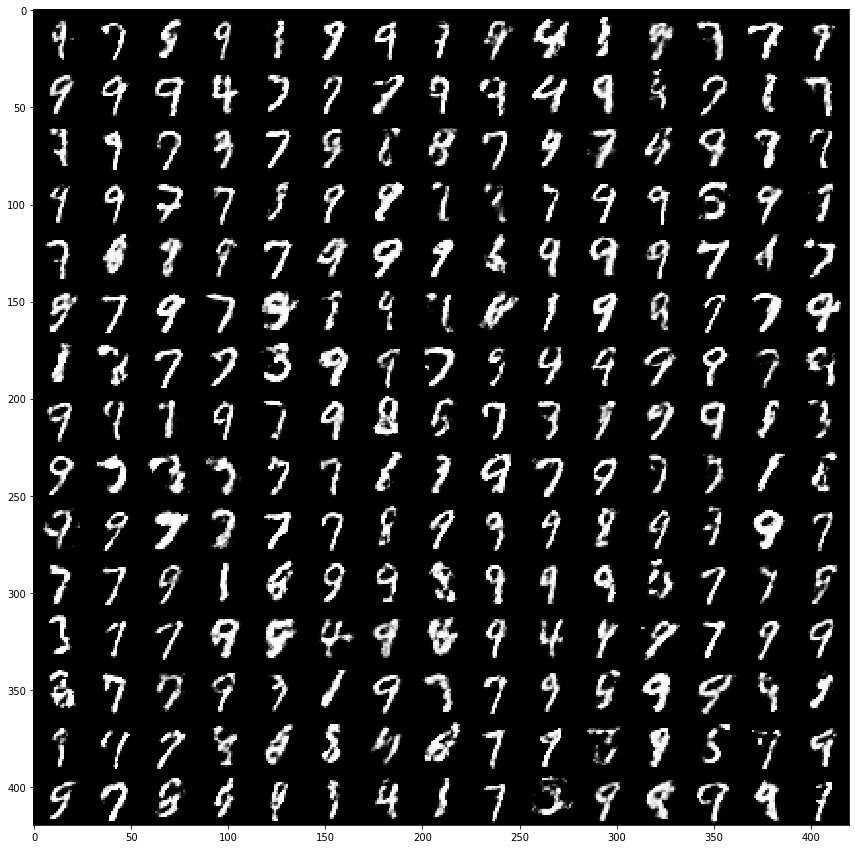

In [43]:
# Generate n*n images from noise, using the generator network.
n = 15
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    # Generate image from noise.
    g = sess.run(generator(gen_input), feed_dict={gen_input: z})

    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

## Next steps to take it from here

- We can notice that some digits are generated more frequent than others, why is that. Implement an approach that does solve this issue or at least weaken the effect.
- So far we have only evaluated the performance of the generator qualitatively. How could a quantitative evaluation look like? Implement a quantitative evaluation.
